# Chapter 5: The forecaster's toolbox

- describe some benchmark forecasting methods
- procedures for checking whether a forecasting method has adequately utilized the available information
- techniques for computing prediction intervals
- methods for evaluating forecast accuracy 

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "grid.alpha": 1.0,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

mpl.colormaps.register(
    mpl.colors.ListedColormap(
        ["#000000", "#2f2fff"], name="black_and_blue"),
    force=True,
)
mpl.colormaps.register(
    mpl.colors.ListedColormap(
        ["#000000", "#000000"], name="all_black"),
    force=True,
)
mpl.colormaps.register(
    mpl.colors.ListedColormap(
        ["#000000", "#D55F03", "#569CC6", "#13A076", "#CC79A7"],
        name='black_and_4color',
    ),
    force=True
)
mpl.colormaps.register(
    mpl.colors.ListedColormap(
        ["#000000", "#D55F03", "#569CC6", "#13A076"],
        name='black_and_3color',
    ),
    force=True
)
mpl.colormaps.register(
    mpl.colors.ListedColormap(
        ["#D55F03", "#569CC6", "#13A076", "#CC79A7"],
        name='r_colors',
    ),
    force=True
)

In [3]:
from functools import partial
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape as _mape, mase, quantile_loss, mqloss
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
)
from fpppy.models import LinearRegression

def mape(df, models, id_col = "unique_id", target_col = "y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape

/Users/david/dev/fpp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5.1 A tidy forecasting workflow

To illustrate the workflow, we'll fit linear trend models to national GDP data in `global_economy`. 

### Data prepation 
- load data
- identify missing values 
- filtering the time series 
- other pre-processing

We'll model GDP per capita over time, so we must compute the relevant variable first:

In [4]:
gdp_df = (
    pd.read_csv("./data/global_economy.csv", parse_dates=["ds"])[["unique_id", "ds", "GDP", "Population"]]  # read data from csv and select relevant columns
    .assign(                                                            # assign new columns to the dataframe
        GDP=lambda x: x["GDP"].interpolate(),                           # handle missing values in GDP by interpolation
        Population=lambda x: x["Population"].interpolate(),             # handle missing values in Population by interpolation
        y=lambda x: x["GDP"] / x["Population"],                         # compute GDP per capita as the target variable
    )
)

In [5]:
gdp_df.head()

,unique_id,ds,GDP,Population,y
0,Afghanistan,1960-01-01,5.378e+08,8.996e+06,59.777
1,Afghanistan,1961-01-01,5.489e+08,9.167e+06,59.878
2,Afghanistan,1962-01-01,5.467e+08,9.346e+06,58.493
3,Afghanistan,1963-01-01,7.511e+08,9.534e+06,78.783
4,Afghanistan,1964-01-01,8.000e+08,9.731e+06,82.208


### Plot the data 

For example, we can plot the gdp data for Sweden:

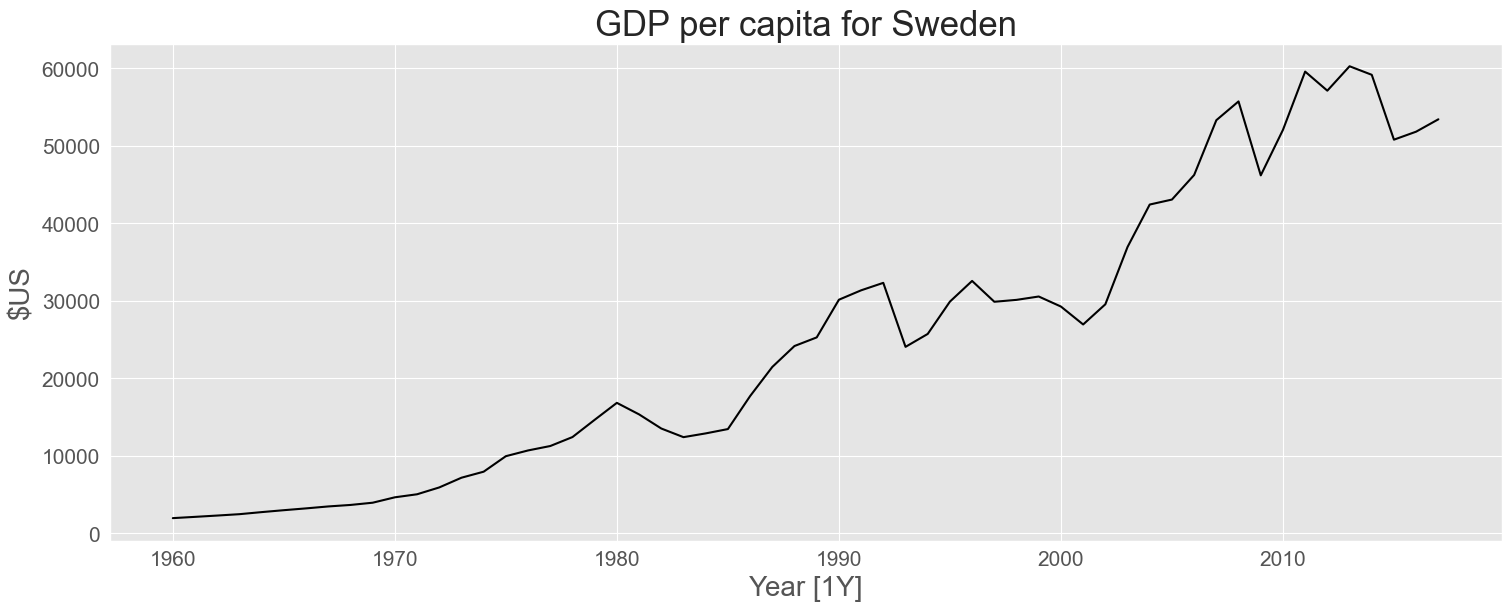

In [6]:
plot_series(gdp_df, ids=["Sweden"],
    xlabel="Year [1Y]", ylabel="$US", title="GDP per capita for Sweden")

### Define a model
The `StatsForecast` package comes with many statistical models already implemented, and it's possible to use models from `scikit-learn` with `StatsForecast`. For example, a linear trend model can be specified with the corresponding exogenous variables and using the following to specify the models:
```python
SklearnModel(LinearRegression())
```

### Train the model (estimate parameters)

To train the model, we must first remove unused columns and rows:

In [7]:
sweden_df = (
    gdp_df
    .loc[lambda x: x["unique_id"] == "Sweden"]
    [["unique_id", "ds", "y"]]
)
sweden_df.head()

,unique_id,ds,y
13324,Sweden,1960-01-01,1983.107
13325,Sweden,1961-01-01,2147.229
13326,Sweden,1962-01-01,2315.847
13327,Sweden,1963-01-01,2492.545
13328,Sweden,1964-01-01,2758.943


In [8]:
sweden_df['unique_id'].unique()

<ArrowStringArray>
['Sweden']
Length: 1, dtype: str

Now we can fit a linear trend model to the GDP per capita data for each combination of key variables. We create these variables using `pipeline()` and specify that we want the `trend` feature; then, we initialize a `StatsForecast` object that will handle the forecasting process.

In [9]:
train_features, valid_features = pipeline(
    sweden_df, features=[trend], freq="YE", h=3)

trend_model = SklearnModel(LinearRegression())
sf = StatsForecast(models=[trend_model], freq="YE")

### Evaluate model performance
See sections 5.8-5.9

### Produce forecasts
You can use the `forecast()` method by specifying the number of future observations to forecast. 

It can also be more convenient to provide a dataset of future time periods to forecast, e.g. when your model uses additional information from the data such as exogenous regressors. Additional data required by the model can be included in the dataset of observations to forecast. 

In [10]:
sf.fit(df=train_features)
fcasts = sf.predict(h=3, X_df=valid_features)

# We are using a LinearRegression wrapper that provides
# the following method for calculating prediction intervals
model = sf.fitted_[0][0].model_["model"]
fcasts = model.add_prediction_intervals(
    fcasts, valid_features.rename(columns={"trend": "x1"}))
fcasts

,unique_id,ds,LinearRegression,LinearRegression-lo-95,LinearRegression-hi-95,LinearRegression-lo-80,LinearRegression-hi-80
0,Sweden,2017-12-31,56165.506,46066.615,66264.397,49570.311,62760.700
1,Sweden,2018-12-31,57225.849,47109.566,67342.132,50619.297,63832.401
2,Sweden,2019-12-31,58286.193,48151.970,68420.416,51667.925,64904.461


This is a forecast table. Each row corresponds to one forecast period, and the `LinearRegression` column contains the point forecast. The point forecast is the mean of the forecast distribution. 

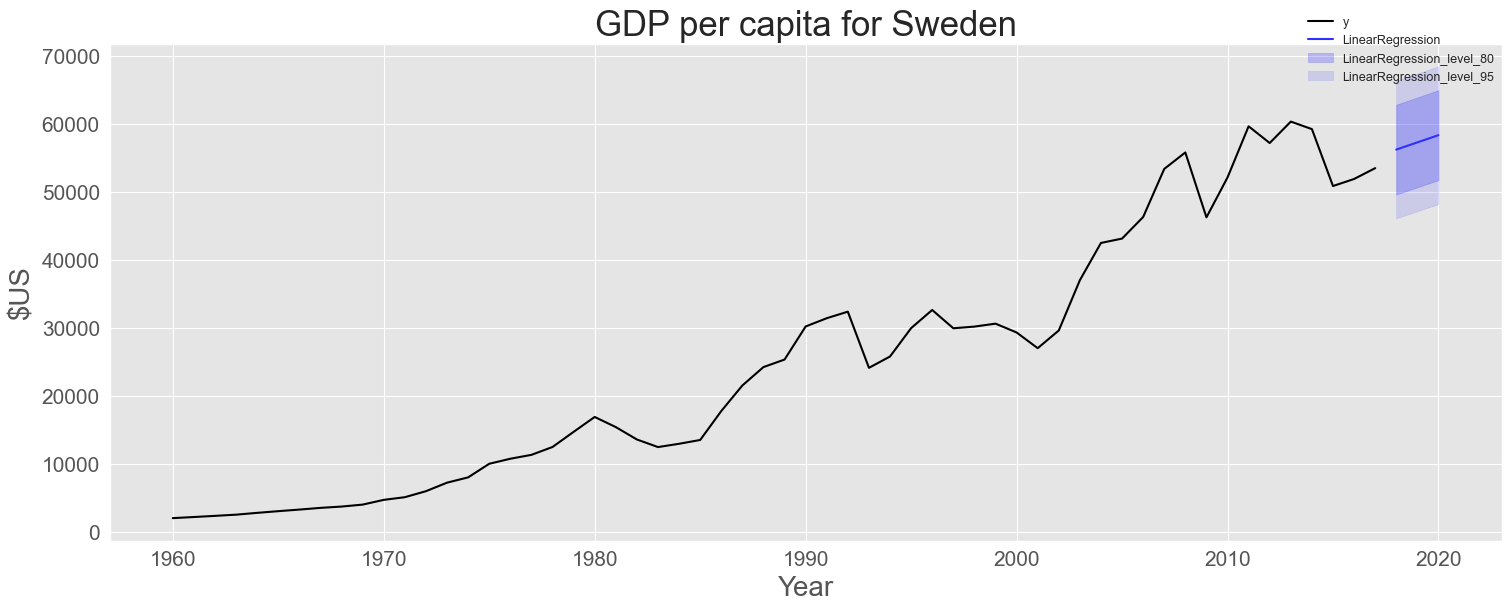

In [11]:
plot_series(sweden_df, fcasts, ids=["Sweden"], level=[80, 95],
    xlabel="Year", ylabel="$US", title="GDP per capita for Sweden",
    palette="black_and_blue", rm_legend=False)

## 5.2 Some simple forecasting methods

Four simple methods will serve as benchmarks throughout the book. To illustrate, we'll use them on quarterly Australian clay brick production between 1970-2004. 

In [12]:
production_df = pd.read_csv("./data/aus_production_formatted.csv", parse_dates=["ds"])
bricks_df = (
    production_df.loc[lambda x: (
        (x["unique_id"] == "Bricks")
        & (x["ds"].between("1970", "2004-12"))
    )]
    .dropna()
)
bricks_df.tail()

,unique_id,ds,y
627,Bricks,2003-12-01,413.0
628,Bricks,2004-03-01,409.0
629,Bricks,2004-06-01,423.0
630,Bricks,2004-09-01,428.0
631,Bricks,2004-12-01,397.0


### Mean method
The forecasts of all future values are equal to the mean of the historical data. I.e. if the historical data is $y_1,\ldots,y_T$, then the forecasts are 
$$
\hat{y}_{T+h|T} = \overline{y} = \frac{y_1 + \ldots + y_T}{T}.
$$

In [13]:
avg_method = HistoricAverage()
sf = StatsForecast(models=[avg_method], freq="QE")
sf.fit(df=bricks_df)
fcasts = sf.predict(h=8)
fcasts

,unique_id,ds,HistoricAverage
0,Bricks,2004-12-31,450.879
1,Bricks,2005-03-31,450.879
2,Bricks,2005-06-30,450.879
3,Bricks,2005-09-30,450.879
4,Bricks,2005-12-31,450.879
5,Bricks,2006-03-31,450.879
6,Bricks,2006-06-30,450.879
7,Bricks,2006-09-30,450.879


### Naive method
Here, we simply set all forecasts to be the value of the last observation. This forecast is optimal when data follow a random walk, so it's good for many economic and financial time series. 

In [14]:
naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq="QE")

### Seasonal naive method
For highly seasonal data, we can set each forecast to be equal to the last observed value from the same season (e.g. same month of the previous year).

In [15]:
seasonal_naive_method = SeasonalNaive(4)                        # since the data is quarterly, we set the seasonal period to 4
sf = StatsForecast(models=[seasonal_naive_method], freq="Q")

### Drift method
A variation on the naive method is to allow forecasts to increase or decrease over time, where the amount of drift is set to be the average change seen in the historical data. Thus the forecast for time $T+h$ is given by 
$$
\hat{y}_{T+h|T} = y_T + \frac{h}{T-1}\sum_{t=2}^T (y_t - y_{t-1}) = y_T + h(\frac{y_T-y_1}{T-1}). 
$$
This is equivalent to drawing a line between the first and last observations, and extrapolating it into the future. 

In [16]:
drift_method = RandomWalkWithDrift()
sf = StatsForecast(models=[drift_method], freq="Q")

### 5.3 Fitted values and residuals 

### Fitted values
Each observation in a time series can be forecast using all previous observations; we call these the **fitted values** and denote them $\hat{y}_{t|t-1}$, meaning the forecast of $y_t$ given the observations $y_1,\ldots,y_{t-1}$. 

? honestly this whole subsection doesn't make a whole lot of sense

### Residuals
The **residuals** are what is left over after fitting a model and are equal to the difference between the observations and the corresponding fitted values: $$e_t = y_t - \hat{y}_t.$$ 

If a transformation has been used in the model, it's often usefull to look at residuals on the transformed scale. These are called the **innovation residuals**. E.g. if we take the log of the data $w_t = \log y_t$, then $w_t - \hat{w}_t$ are the innovation residuals and $y_t - \hat{y}_t$ are the regular residuals. 

The fitted values can be obtained with `forecast_fitted_values()` after running `forecast()` specifying `fitted=True`. We store those values in the `fitted` column and compute the residuals by taking the difference between the `y` column and the `fitted` column. 

In [17]:
beers_df = production_df.loc[
    lambda x: (x["unique_id"] == "Beer") & (x["ds"] >= "1992")
]

train = beers_df.loc[lambda x: x["ds"] < "2007"]
test = beers_df.loc[lambda x: x["ds"] >= "2007"]

avg_method = HistoricAverage()
sf = StatsForecast(models=[avg_method], freq="QE")
sf.forecast(h=14, df=train, fitted=True)
fitted_values = sf.forecast_fitted_values()
df = train.assign(
    fitted=fitted_values["HistoricAverage"].to_numpy(),
    resid=lambda x: x["y"] - x["fitted"],
    innov=lambda x: x["y"] - x["fitted"],
)
df.head()

,unique_id,ds,y,fitted,resid,innov
144,Beer,1992-03-01,443.0,436.45,6.55,6.55
145,Beer,1992-06-01,410.0,436.45,-26.45,-26.45
146,Beer,1992-09-01,420.0,436.45,-16.45,-16.45
147,Beer,1992-12-01,532.0,436.45,95.55,95.55
148,Beer,1993-03-01,433.0,436.45,-3.45,-3.45


Residuals are useful in checking whether a model has adequately captured the information in the data, and we use innovation residuals for this. If patterns are observable in the innovation residuals, then the model can probably be improved. 

## 5.4 Residual diagnostics
A good forecasting method yields innovation residuals with the following properties:
1. The innovation residuals are uncorrelated. If there are correlations, then there's information left in the residuals that can be exploited for forecasts. 
2. The innovation residuals have zero mean. If they have nonzero mean, then the forecasts are biased. 

Note that it's possible to have different forecasting methods for the same dataset, all of which satisfy these properties (and can still be improved). Checking these properties tell you whether a particular method is using all available information, but it's not a good way to select a forecasting method. 

Adjusting for bias is easy: if the residuals have mean $m$, simply add $m$ to all the forecasts to eliminate the bias. Fixing correlation is more difficult (see chapter 10). 

In addition, it's useful (but not necessary) for the residuals to also have the following properties.

3. The innovation residuals have constant variance (homoscedasticity)
4. The innovation residuals are normally distributed. 

Properties 3 and 4 make calculation of prediction intervals easier. However, a method that doesn't satisfy these properties cannot necessarily be improved. Section 5.5 deals with non-normal innovation residuals. 

### Example: Forecasting Google daily closing stock prices
For stock prices, the best forecasting method is often the naive method, $\hat{y_t} = y_{t-1}$. Hence the residuals are equal to the difference between consecutive observations: $$ e_t = y_t - \hat{y}_t = y_t - y_{t-1}.$$

The following graph shows the Google daily closing price for trading days during 2015. 

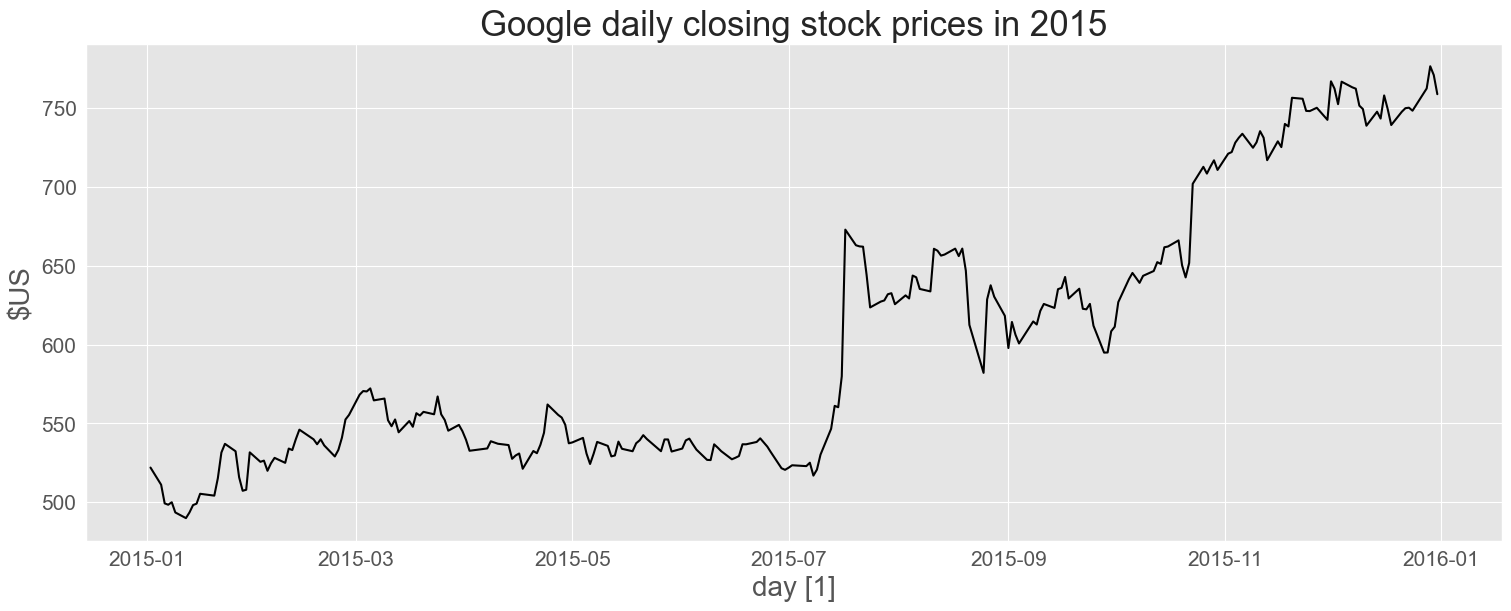

In [18]:
goog_df = (
    pd.read_csv("./data/gafa_stock.csv", parse_dates=["ds"])
    .loc[lambda x: (
        (x["unique_id"] == "GOOG_Close")
        & x["ds"].between("2015", "2016-01-31")
    )]
)

train = goog_df.loc[lambda x: x["ds"].dt.year == 2015]
plot_series(train,
    xlabel="day [1]", ylabel="$US",
    title="Google daily closing stock prices in 2015")

The residuals from the naive method are shown below. 

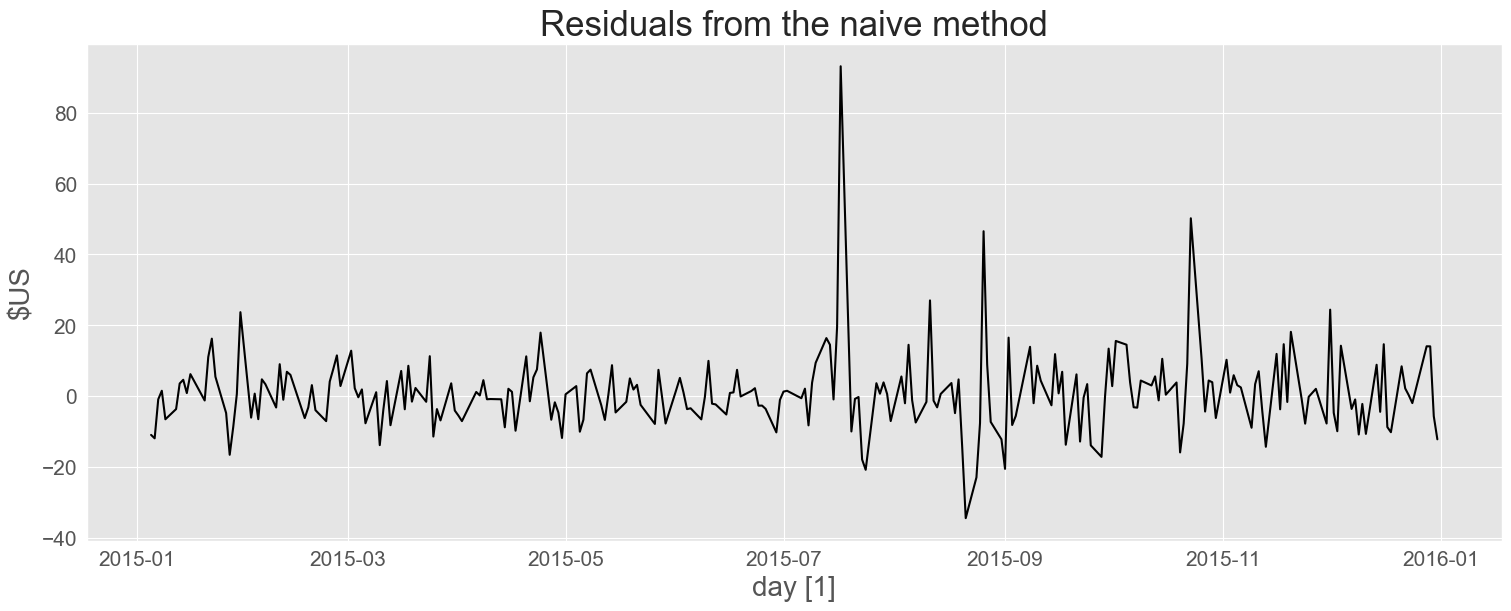

In [19]:
resid = train.assign(resid=lambda x: x["y"].diff())
plot_series(resid, target_col="resid",
    xlabel="day [1]", ylabel="$US",
    title="Residuals from the naive method")

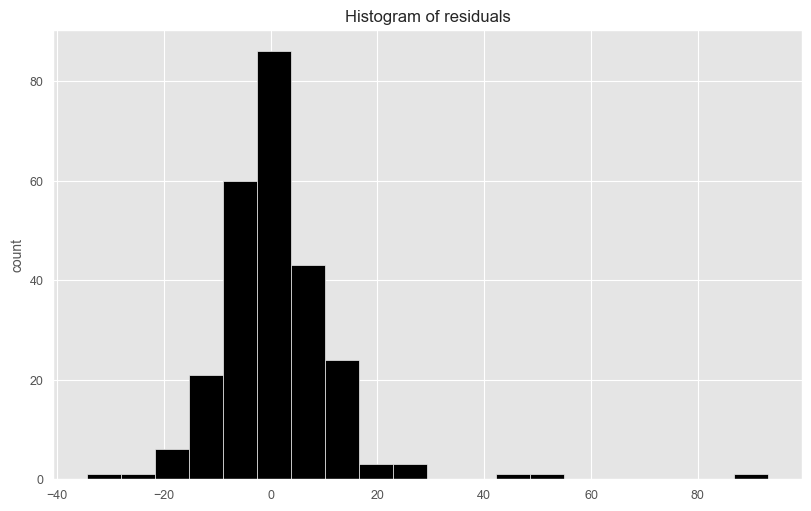

In [20]:
ax = resid["resid"].hist(bins=20)
ax.set(title="Histogram of residuals", ylabel="count")
plt.show()

[Text(0, 0.5, 'acf')]

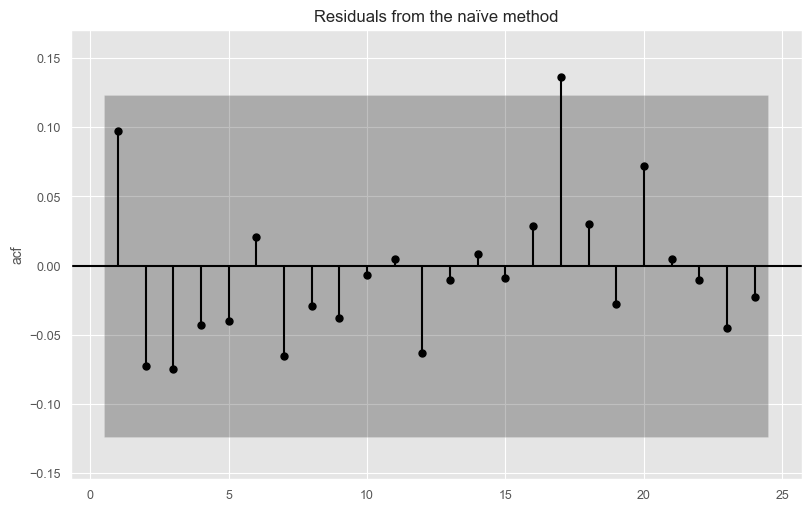

In [21]:
fig = plot_acf(resid["resid"][1:], zero=False, auto_ylims=True,
    bartlett_confint=False, title="Residuals from the naïve method")
fig.axes[0].set(ylabel="acf")

The mean of these residuals is close to zero and there's no significant correlation in the residuals series. The time plot of residuals shows that the variation stays much the same except for the one outlier, so the residual variance can be thought of as constant. The histogram suggests that the residuals might not be normal, since the right tail is long, even ignoring the outlier. 

Consequently, forecasts with this method will probably be good, but predicition intervals that are computed assuming a normal distribution may be inaccurate. 

We can wrap these plots in a convenience function using `plot_diagnostics()`:

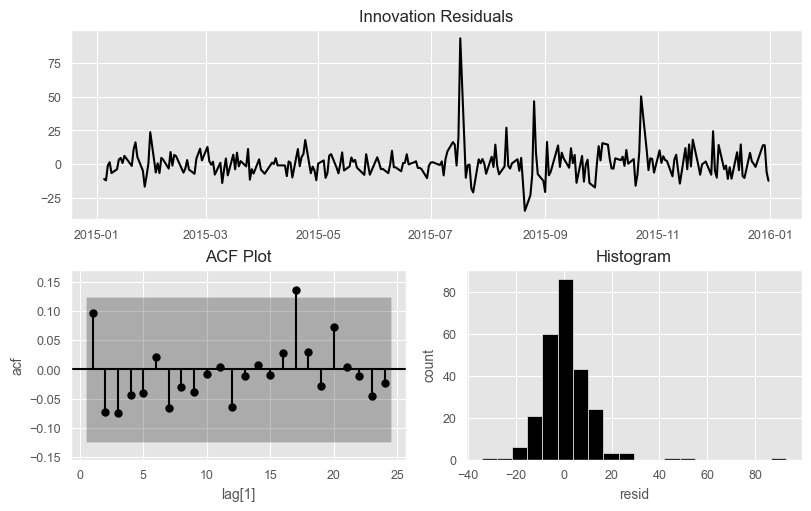

In [22]:
def plot_diagnostics(data):
    _, axes = plt.subplot_mosaic([["resid", "resid"], ["acf", "hist"]])

    ax = axes["resid"]
    ax.plot(data["ds"], data["resid"])
    ax.set(title="Innovation Residuals")

    ax = axes["acf"]
    plot_acf(data["resid"].dropna(),
        zero=False, bartlett_confint=False, auto_ylims=True, ax=ax)
    ax.set(title="ACF Plot", xlabel="lag[1]", ylabel="acf")

    ax = axes["hist"]
    ax.hist(data["resid"], bins=20)
    ax.set(title="Histogram", xlabel="resid", ylabel="count")

plot_diagnostics(resid)

### Portmanteau tests for autocorrelation

In addition to the ACF plot we can do a more formal test for autocorrelation. 

We start by testing whether the first $l$ autocorrelations are significantly different from what would be expected from a white noise process. A test for a group of autocorrelations is a **portmanteau test**.

1. **Box-Pierce test**, based on $$Q = T\sum_{k=1}^l r_k^2,$$ where $l$ is the maximum lag being considered and $T$ is the number of observations. If each $r_k$ is small, then Q will be small. If some $r_k$ values are large in either direction, then $Q$ will be large. 
- suggest $l=10$ for non-seasonal data and $l=2m$ for seasonal data with seasonal period $m$. 
- however, the test isn't good when $l$ is large, so if either of these is larger than $T/5$, then use $l= T/5$. 
2. **Ljung-Box test**, more accurate. Based on $$Q^* = T(T+2)\sum_{k=1}^l(T-k)^{-1}r_k^2$$

How large is too large? If the autocorrelations did come from a white noise series, then both $Q$ and $Q^*$ would have a $\chi^2$ distribution with $l$ degrees of freedom. 

The following code shows results for $l\in[1,10]$. 

In [23]:
resid_test = acorr_ljungbox(resid["resid"].dropna(), boxpierce=True)
resid_test

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.417,0.120,2.389,0.122
2,3.761,0.153,3.711,0.156
3,5.193,0.158,5.115,0.164
4,5.675,0.225,5.585,0.232
5,6.084,0.298,5.983,0.308
6,6.195,0.402,6.090,0.413
7,7.303,0.398,7.159,0.413
8,7.525,0.481,7.372,0.497
9,7.902,0.544,7.733,0.561
10,7.914,0.637,7.745,0.654


Since the p-values are relatively large, the results aren't significant. Thus we can conclude that the residuals are not distinguishable from white noise. 

## 5.5 Distributional forecasts and prediction intervals

### Forecast distributions

- We express uncertainty in our forecasts using a probability distribution
- the point forecast is the mean of this distribution
- Most time series models produce normally distributed forecasts, i.e. we assume that the distribution of possible futures values follows a normal distribution

### Prediction intervals
- A **prediction interval** gives an interval within which we expect $y_t$ to lie with a specified probability. E.g. assuming the distribution of future forecasts is normal, a $95$% prediction interval for the $h$-step forecast is $$\hat{y}_{T+h|T}\pm 1.96\hat{\sigma}_h,$$ where $\hat{\sigma}_h$ is an estimate of the standard deviation of the $h$-step forecast distribution.
- More generally, a prediction interval can be written $$\hat{y}_{T+h|T}\pm c\hat{\sigma}_h,$$ where the multiplier $c$ depends on the coverage probability, e.g. depends on if we want an $80$% or an $95$% etc interval. 
- point forecasts can be of almost no value without accompanying prediction intervals, since they indicate the uncertainty in the forecasts

### One-step prediction intervals
When forecasting one step ahead, the standard deviation of the forecast distribution can be estimated using the std dev of the residuals given by $$ \hat{\sigma_r} = \sqrt{\frac{1}{T-K-M}\sum_{t=1}^Te_t^2},$$ where $K$ is the number of parameters estimated in the forecasting method and $M$ is the number of missing values in the residuals (e.g. $M=1$ in the native method since we can't forecast the first observation). 

### Multi-step prediction intervals
- Prediction intervals usually increase in width as the forecast horizon increases
- I.e. $\sigma_h$ usually increases with $h$, though some non-linear forecasting methods don't have this property
- For one-step forecasts, the above equation for $\hat{\sigma_r}$ provides a good estimate of the forecast std dev $\sigma_1$. For multi-step forecasts, we need a more complicated method (that assumes that the residuals are uncorrelated)

### Benchmark methods
For the four standard benchmarks, it's possible to derive the forecast std dev, assuming uncorrelated residuals. If $\hat{sigma_h}$ is the standard deviation of the $h$-step forecast distribution, and $\hat{\sigma_r}$ is the residual standard deviation given above. The expressions for $h$-step forecast standard deviation of the standard benchmarks are as follows. Note that when $h=1$ and $T$ is large, these give the same approximate value.
- **Mean:** $$\hat{\sigma}_h = \hat{\sigma_r}\sqrt{1+\frac{1}{T}}$$
- **Naive:** $$\hat{\sigma}_h = \hat{\sigma_r}\sqrt{h}$$
- **Seasonal naive:** $$\hat{\sigma}_h = \hat{\sigma_r}\sqrt{k+1}$$
- **Drift:** $$\hat{\sigma}_h = \hat{\sigma_r}\sqrt{h(1+\frac{h}{T-1})}$$
where $\hat{\sigma}_r$ is the residual standard deviation, $m$ is the seasonal period, and $k$ is the integer part of $\frac{h-1}{m}$ (i.e the number of complete years in the forecast period prior to time $T+h$).

Here's an example of computing prediction intervals with `statsforecast` using the naive method for Google stock price:

In [ ]:
train = goog_df.loc[lambda x: x["ds"].dt.year == 2015].copy()
train["ds"] = np.arange(len(train))
naive_method = Naive()
sf = StatsForecast(models=[naive_method], freq=1)
fcasts = sf.forecast(df=train, h=10, level=[80, 95])        # level allows us to specify the prediction intervals
fcasts

,unique_id,ds,Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,GOOG_Close,252,758.88,744.540,736.949,773.220,780.811
1,GOOG_Close,253,758.88,738.600,727.865,779.160,789.895
2,GOOG_Close,254,758.88,734.042,720.894,783.718,796.866
3,GOOG_Close,255,758.88,730.200,715.018,787.560,802.742
4,GOOG_Close,256,758.88,726.815,709.840,790.945,807.920
5,GOOG_Close,257,758.88,723.754,705.160,794.006,812.600
6,GOOG_Close,258,758.88,720.940,700.856,796.820,816.904
7,GOOG_Close,259,758.88,718.320,696.849,799.440,820.911
8,GOOG_Close,260,758.88,715.860,693.086,801.900,824.674
9,GOOG_Close,261,758.88,713.533,689.528,804.227,828.232


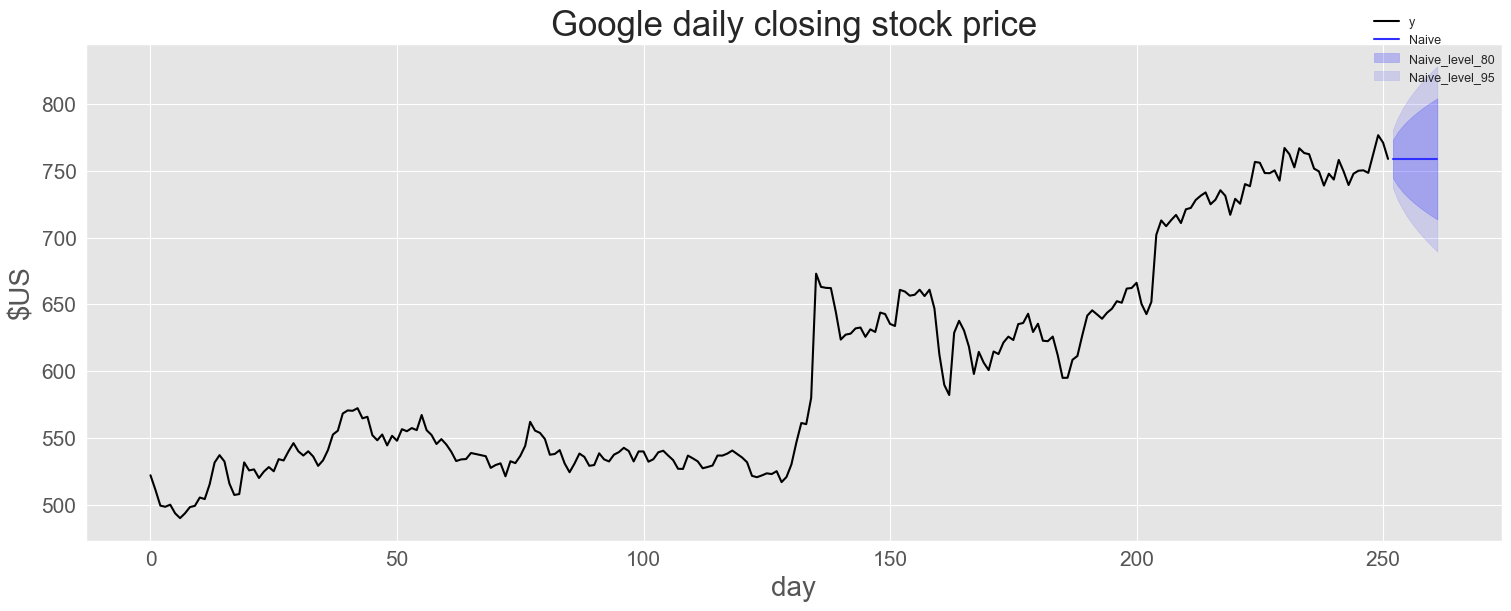

In [25]:
plot_series(train, fcasts, level=[80, 95],
    xlabel="day", ylabel="$US",
    title="Google daily closing stock price",
    palette="black_and_blue", rm_legend=False)

### Prediction intervals from bootstrapped residuals
When a normal distribution for the residuals is an unreasonable assumption, one can use **bootstrapping**, which only assumes that the residuals are uncorrelated and with constant variance. The procedure is illustrated using a naive forecasting method. 

A one-step forecast error is $e_t = y_t - \hat{y}_{t|t-1}$. For the naive method, $\hat{y}_{t|t-1} = y_{t-1}$, so we can write the residual equation as $$y_t = y_{t-1}+e_t.$$

If we assume future errors will be similar to past errors, then when $t>T$ we can replace $e_t$ by sampling from the residuals we've seen in the past. So we can simulate the next observation of a time series using $$y^*_{T+1} = y_T + e^*_{T+1},$$ where $e^*_{T+1}$ is a randomly sampled residual from the past and $y^*_{T+1}$ is the possible future value that would arise if that particular error value occurred. We use a $*$ to indicate that this isn't the observed $y_{T+1}$ value but rather one possible future that could occur. 

Adding the new simulated observation to our data set, we can repeat the process to obtain $$y^*_{T+2} = y^*_{T+1} + e^*_{T+2},$$ where $e^*_{T+2}$ is another draw from the collection of residuals. Continuing, we can simulate an entire set of future values for our time series.

Doing this reapeatedly, we obtain many possible futures. See below for a generation of five possible sample paths for the next 30 trading days. 

In [26]:
sf = StatsForecast(models = [Naive()], freq=1)
sf.forecast(h=30, df=train, fitted=True)
fitted = sf.forecast_fitted_values()
errors = (fitted["y"] - fitted["Naive"]).iloc[1:].to_list()
last_obs = train["y"].iloc[-1]

def generate_sim_df(num_sims, h):
    steps = np.random.choice(errors, size=(num_sims, h))
    sims = last_obs + steps.cumsum(axis=1)
    return pd.DataFrame({
        f"sim_{i}": sim
        for (i, sim) in enumerate(sims)
    })


sim_df = generate_sim_df(num_sims=5, h=30).assign(
    unique_id="GOOG_Close",
    ds=lambda x: train["ds"].max() + 1 + x.index,
)

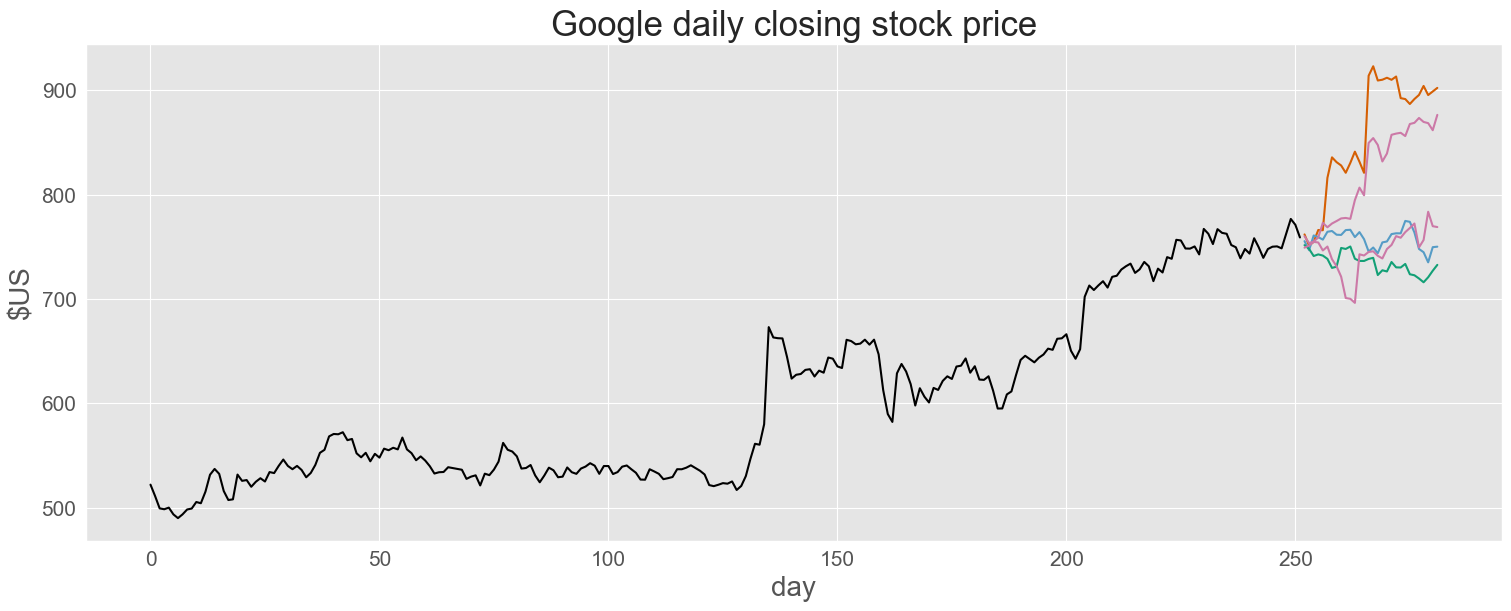

In [27]:
plot_series(train, sim_df,
    models = ["sim_0", "sim_1", "sim_2", "sim_3", "sim_4"],
    xlabel="day", ylabel="$US",
    palette="black_and_4color", title="Google daily closing stock price",
)

Then we can compute prediction intervals by calculating percentiles of the future sample paths for each forecast horizon. The result is the **bootstrapped** prediction interval. 

In [28]:
raw_df = generate_sim_df(num_sims=5000, h=30)
sim_df = raw_df.assign(**{
    "unique_id": "GOOG_Close",
    "ds": train["ds"].max() + 1 + raw_df.index,
    "bootstrap": raw_df.mean(axis="columns"),
    "bootstrap-lo-95": raw_df.quantile(0.025, axis="columns"),
    "bootstrap-lo-80": raw_df.quantile(0.1, axis="columns"),
    "bootstrap-hi-80": raw_df.quantile(0.9, axis="columns"),
    "bootstrap-hi-95": raw_df.quantile(0.975, axis="columns"),
})

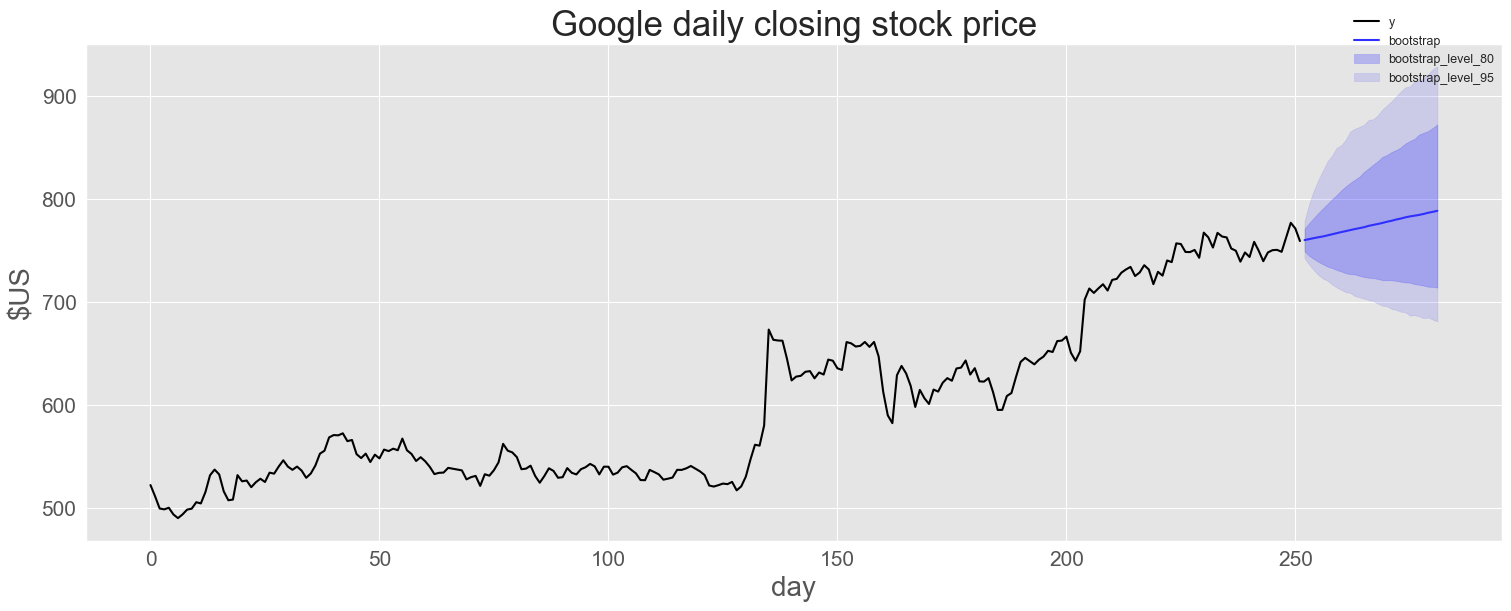

In [29]:
plot_series(
    train, sim_df, models=["bootstrap"], level=[80, 95],
    xlabel="day", ylabel="$US", rm_legend=False,
    palette="black_and_blue", title="Google daily closing stock price")

### Conformal prediction for distribution-free prediction intervals
Traditional prediction intervals rely on assumptions about the forecast distribution like normality. Contrastingly, conformal prediction offers a model-agnostic alternative that doesn't require strong distributional assumptions.

Instead of estimating intervals based on a predefined probabilistic model, conformal prediction constructs intervals using past forecast errors.

#### Constructing conformal prediction intervals